In [20]:
# imports
import torch
from torch import nn
from torch.nn import functional as F

import math
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
from datetime import datetime as dt
import os

import pickle as pkl

In [3]:
# set seed
_ = torch.manual_seed(13)

In [4]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [5]:
transform = transforms.ToTensor()

train_set = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, num_workers=0
)

## Visualize the data

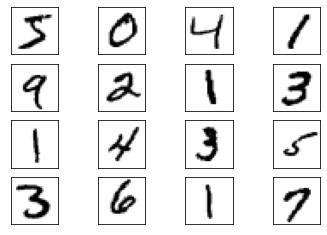

In [6]:
real_samples, mnist = next(iter(train_loader))
for (index, image) in enumerate(real_samples[0:16]):
    ax = plt.subplot(4, 4, index + 1)
    plt.imshow(image.reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Models

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)

        return out


class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = torch.tanh(self.fc4(x))

        return out

## Hyper Params

In [26]:
input_size = 784
d_output_size = 1
d_hidden_size = 32

z_size = 100
g_output_size = 784
g_hidden_size = 32

In [27]:
D = Discriminator(input_size, d_hidden_size, d_output_size).to(device=device)
G = Generator(z_size, g_hidden_size, g_output_size).to(device=device)

## Losses

In [28]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [29]:
lr = 0.002

d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

## Saving and loading functions

In [45]:
def save_checkpoint(state, is_best, checkpoint_dir):
    file_path = f"{checkpoint_dir}/checkpoint.pt"
    torch.save(state, file_path)
    if is_best: 
        best_fpath = f"{checkpoint_dir}/best_model.pt"
        torch.save(state, best_fpath)

## Training

In [101]:
start_at_epoch = 1
num_epochs = 100

samples = []
losses = []

print_every = 400

sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

load_checkpoint = True
load_path = "./model/2021-05-26T13:28:18/checkpoint.pt"

if load_checkpoint: 
    checkpoint = torch.load(load_path)
    G.load_state_dict(checkpoint["gen_state_dict"])
    D.load_state_dict(checkpoint["disc_state_dict"])
    g_optimizer.load_state_dict(checkpoint["gen_optim_state_dict"])
    d_optimizer.load_state_dict(checkpoint["disc_optim_state_dict"])
    start_at_epoch = checkpoint["epoch"] + 1
    print("Checkpoint loaded")
else:
    print("Starting from beginning")

Checkpoint loaded


In [102]:
now = dt.now()
stamp = now.strftime("%Y-%m-%dT%H:%M:%S")
path = f"model/{stamp}"
os.mkdir(path)

best_g_loss = math.inf

D.train()
G.train()
for epoch in range(start_at_epoch, start_at_epoch + num_epochs):
    
    epoch_start_time = time.time()

    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs + start_at_epoch, d_loss.item(), g_loss.item()))
            
    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
    
    # Save training generator samples
    with open(f"{path}/train_samples.pkl", 'wb') as f:
        pkl.dump(samples, f)
        
    # Save checkpoint
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        best_model = True
    else:
        best_model = False
    state = {
        "epoch": epoch,
        "gen_state_dict": G.state_dict(),
        "disc_state_dict": D.state_dict(),
        "gen_optim_state_dict": g_optimizer.state_dict(),
        "disc_optim_state_dict": d_optimizer.state_dict(),
        "gen_loss": g_loss,
        "disc_loss": d_loss,
    }
    save_checkpoint(state, best_model, path)
    
    
    # print time
    print(f"Time for epoch: {time.time() - epoch_start_time}")

Epoch [  202/  301] | d_loss: 1.1366 | g_loss: 1.4079
Epoch [  202/  301] | d_loss: 1.2172 | g_loss: 1.2275
Epoch [  202/  301] | d_loss: 1.3091 | g_loss: 1.0400
Time for epoch: 9.529059410095215
Epoch [  203/  301] | d_loss: 1.2093 | g_loss: 1.1122
Epoch [  203/  301] | d_loss: 1.3172 | g_loss: 1.2920
Epoch [  203/  301] | d_loss: 1.2309 | g_loss: 1.0112
Time for epoch: 9.970277309417725
Epoch [  204/  301] | d_loss: 1.2307 | g_loss: 1.1637
Epoch [  204/  301] | d_loss: 1.1326 | g_loss: 1.0469
Epoch [  204/  301] | d_loss: 1.3453 | g_loss: 0.9801
Time for epoch: 9.127006769180298
Epoch [  205/  301] | d_loss: 1.1516 | g_loss: 1.0883
Epoch [  205/  301] | d_loss: 1.2367 | g_loss: 1.1268
Epoch [  205/  301] | d_loss: 1.3424 | g_loss: 1.1602
Time for epoch: 8.71541452407837
Epoch [  206/  301] | d_loss: 1.3388 | g_loss: 1.3336
Epoch [  206/  301] | d_loss: 1.2068 | g_loss: 1.0551
Epoch [  206/  301] | d_loss: 1.3088 | g_loss: 1.0716
Time for epoch: 10.3451087474823
Epoch [  207/  301] | 

Epoch [  244/  301] | d_loss: 1.2094 | g_loss: 1.2077
Epoch [  244/  301] | d_loss: 1.4077 | g_loss: 0.9415
Time for epoch: 9.22758173942566
Epoch [  245/  301] | d_loss: 1.2567 | g_loss: 1.0382
Epoch [  245/  301] | d_loss: 1.1868 | g_loss: 1.6296
Epoch [  245/  301] | d_loss: 1.3839 | g_loss: 0.8874
Time for epoch: 9.169160842895508
Epoch [  246/  301] | d_loss: 1.2428 | g_loss: 1.8569
Epoch [  246/  301] | d_loss: 1.1879 | g_loss: 1.1936
Epoch [  246/  301] | d_loss: 1.2660 | g_loss: 1.0876
Time for epoch: 9.106731653213501
Epoch [  247/  301] | d_loss: 1.0674 | g_loss: 2.2137
Epoch [  247/  301] | d_loss: 1.2488 | g_loss: 1.1214
Epoch [  247/  301] | d_loss: 1.2666 | g_loss: 1.0295
Time for epoch: 9.318987846374512
Epoch [  248/  301] | d_loss: 1.2212 | g_loss: 1.2260
Epoch [  248/  301] | d_loss: 1.1427 | g_loss: 1.0318
Epoch [  248/  301] | d_loss: 1.3425 | g_loss: 1.1116
Time for epoch: 9.13181757926941
Epoch [  249/  301] | d_loss: 1.1368 | g_loss: 1.8004
Epoch [  249/  301] | 

Epoch [  286/  301] | d_loss: 1.2376 | g_loss: 0.9776
Epoch [  286/  301] | d_loss: 1.2385 | g_loss: 0.9945
Time for epoch: 13.776757955551147
Epoch [  287/  301] | d_loss: 1.1367 | g_loss: 1.9170
Epoch [  287/  301] | d_loss: 1.1943 | g_loss: 1.4270
Epoch [  287/  301] | d_loss: 1.2991 | g_loss: 1.1102
Time for epoch: 12.23484206199646
Epoch [  288/  301] | d_loss: 1.3075 | g_loss: 1.3977
Epoch [  288/  301] | d_loss: 1.2632 | g_loss: 1.0338
Epoch [  288/  301] | d_loss: 1.2183 | g_loss: 1.1849
Time for epoch: 10.358972787857056
Epoch [  289/  301] | d_loss: 1.2383 | g_loss: 1.1354
Epoch [  289/  301] | d_loss: 1.2498 | g_loss: 1.2477
Epoch [  289/  301] | d_loss: 1.2095 | g_loss: 1.2476
Time for epoch: 12.197819709777832
Epoch [  290/  301] | d_loss: 1.1834 | g_loss: 1.5732
Epoch [  290/  301] | d_loss: 1.2504 | g_loss: 1.2524
Epoch [  290/  301] | d_loss: 1.2917 | g_loss: 1.2752
Time for epoch: 10.675357818603516
Epoch [  291/  301] | d_loss: 1.1194 | g_loss: 1.2789
Epoch [  291/  3

## Plot Training Loss

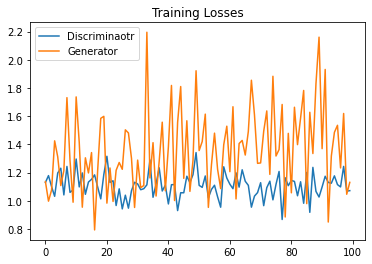

In [103]:
fig, ax = plt.subplots()
np_losses = np.array(losses)
plt.plot(np_losses.T[0], label="Discriminaotr")
plt.plot(np_losses.T[1], label="Generator")
plt.title("Training Losses")
plt.legend()

In [104]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [105]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

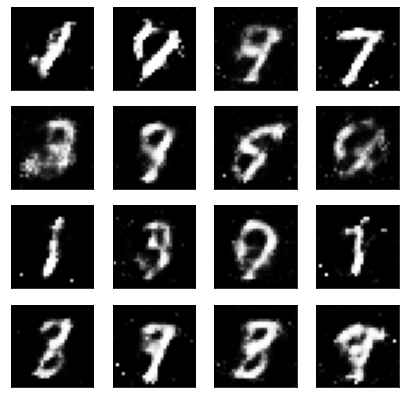

In [106]:
view_samples(-1, samples)

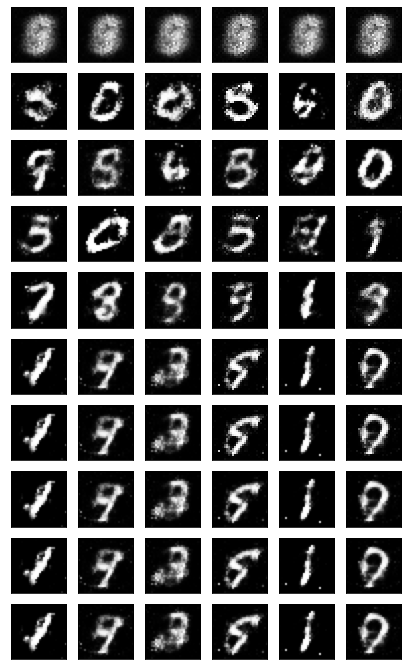

In [113]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


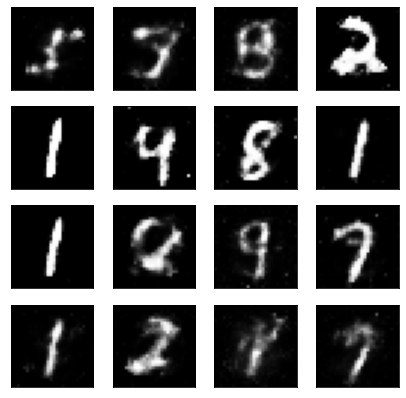

In [112]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])